# Naive Bayes classifier

To classify the emotions, we can use the Naive Bayes classifier.

We will use the [Twitter dataset](https://huggingface.co/datasets/dair-ai/emotion/) for this task.

### Install dependencies

In [70]:
pip install datasets matplotlib numpy spacy scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 10.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


### Get the Dataset

In [155]:
from datasets import load_dataset

def split_dataset(dataset, train_ratio: float = 0.8,
                  test_ratio: float = 0.1,
                  val_ratio: float = 0.1):
    length = len(dataset["train"])
    # shuffle the dataset
    dataset["train"] = dataset["train"].shuffle()
    train_set = dataset["train"].select(range(int(length * 0.8)))
    test_set = dataset["train"].select(range(int(length * 0.1), int(length * (train_ratio + test_ratio))))
    val_set = dataset["train"].select(range(int(length * (train_ratio + test_ratio)), length))
    return train_set, test_set, val_set

def load_twitter_dataset(split = "split"):
    if split not in ["split", "unsplit"]:
        raise ValueError("split must be either 'split' or 'unsplit'")
    ds = load_dataset("dair-ai/emotion", split)

    # Get the train, validation and test sets
    train_set, test_set, val_set = None, None, None

    if split == "split":
        train_set = ds["train"]
        test_set = ds["test"]
        val_set = ds["validation"]
    else:
        # Split the training, validation and test sets, because the "unsplit" dataset only has a training set
        train_set, test_set, val_set = split_dataset(ds)

    # Make sure the dataset is in the right format and in memory
    train_set = train_set.map(lambda x: {"text": x["text"], "label": x["label"]})
    test_set = test_set.map(lambda x: {"text": x["text"], "label": x["label"]})
    val_set = val_set.map(lambda x: {"text": x["text"], "label": x["label"]})

    emotions = [
        "sadness",
        "joy",
        "love",
        "anger",
        "fear",
        "surprise",
    ]


    return train_set, test_set, val_set, emotions

def load_goemotions_dataset(split = "simplified"):
    if split not in ["simplified", "raw"]:
        raise ValueError("split must be either 'simplified' or 'raw'")
    ds = load_dataset("google-research-datasets/go_emotions", "simplified")

    train_set, test_set, val_set = None, None, None

    if split == "simplified":
        # Get the train and test sets
        train_set = ds["train"]
        test_set = ds["test"]
        val_set = ds["validation"]
    else:
        # Get the train, validation and test sets
        train_set, test_set, val_set = split_dataset(ds)

    # Make sure the dataset is in the right format and in memory
    train_set = train_set.map(lambda x: {"text": x["text"], "label": x["labels"][0]})
    test_set = test_set.map(lambda x: {"text": x["text"], "label": x["labels"][0]})
    val_set = val_set.map(lambda x: {"text": x["text"], "label": x["labels"][0]})

    emotions = [
        "admiration",
        "amusement",
        "anger",
        "annoyance",
        "approval",
        "caring",
        "confusion",
        "curiosity",
        "desire",
        "disappointment",
        "disapproval",
        "disgust",
        "embarrassment",
        "excitement",
        "fear",
        "gratitude",
        "grief",
        "joy",
        "love",
        "nervousness",
        "optimism",
        "pride",
        "realization",
        "relief",
        "remorse",
        "sadness",
        "surprise",
        "neutral",
    ]

    return train_set, test_set, val_set, emotions


# train_set, test_set, val_set, __emotions = load_twitter_dataset("split")
google_train_set, google_test_set, google_val_set, google__emotions = load_goemotions_dataset("simplified")

train_set, test_set, val_set, __emotions = google_train_set, google_test_set, google_val_set, google__emotions

EMOTION_TO_INDEX = {
    emotion: index for index, emotion in enumerate(__emotions)
}

INDEX_TO_EMOTION = {
    index: emotion for emotion, index in EMOTION_TO_INDEX.items()
}

### List the different emotions in the dataset

### Analyse our Dataset

In [39]:
import matplotlib.pyplot as plt

def get_label_count(dataset, labels: list[str]):
    index_to_label = {index: label for index, label in enumerate(labels)}
    count = {label: 0 for label in labels}
    for data in dataset:
        count[index_to_label[data["label"]]] += 1
    return count

def plot_label_distribution(dataset, labels: list[str], *, title: str):
    count = get_label_count(dataset, labels)
    plt.figure(figsize=(15, 6))
    plt.bar(count.keys(), count.values())

    plt.xticks(rotation=60)

    plt.title(title, fontsize=15)

    plt.show()

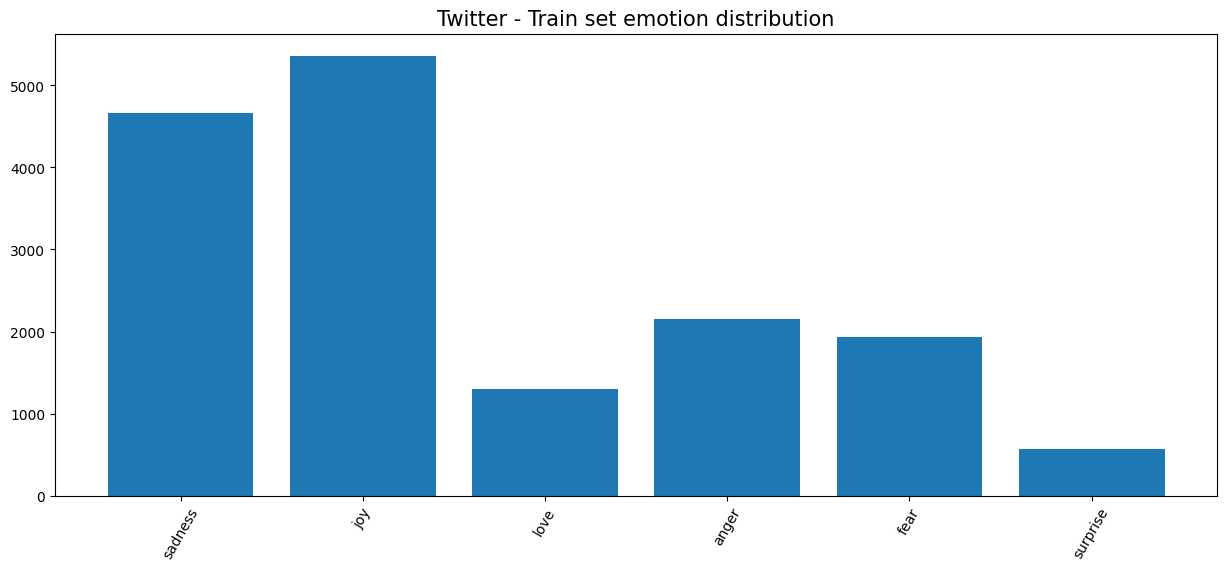

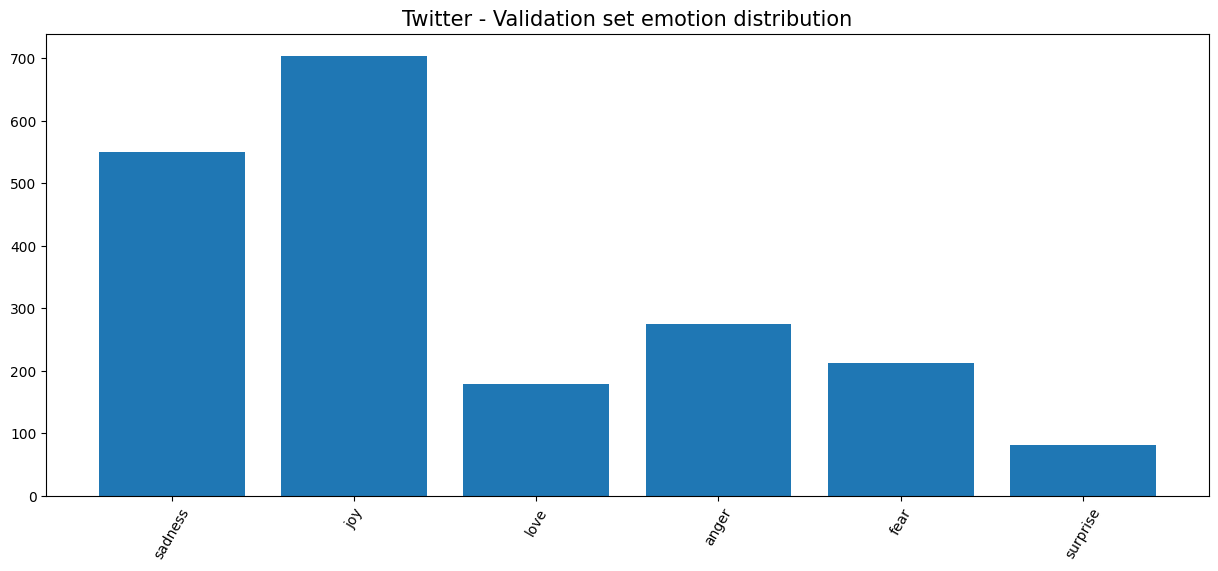

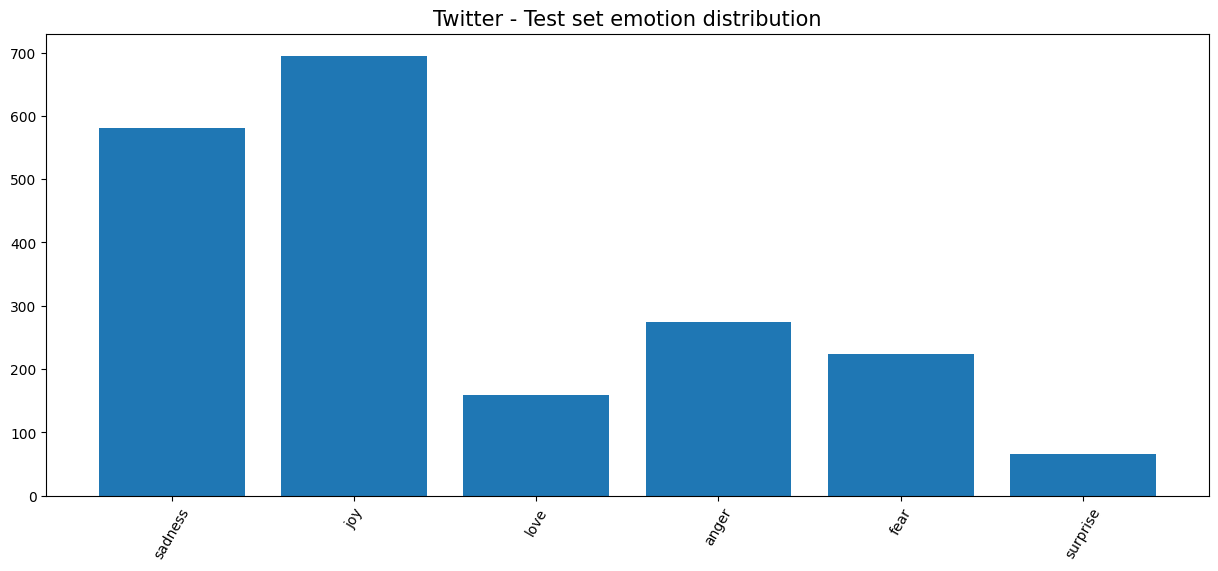

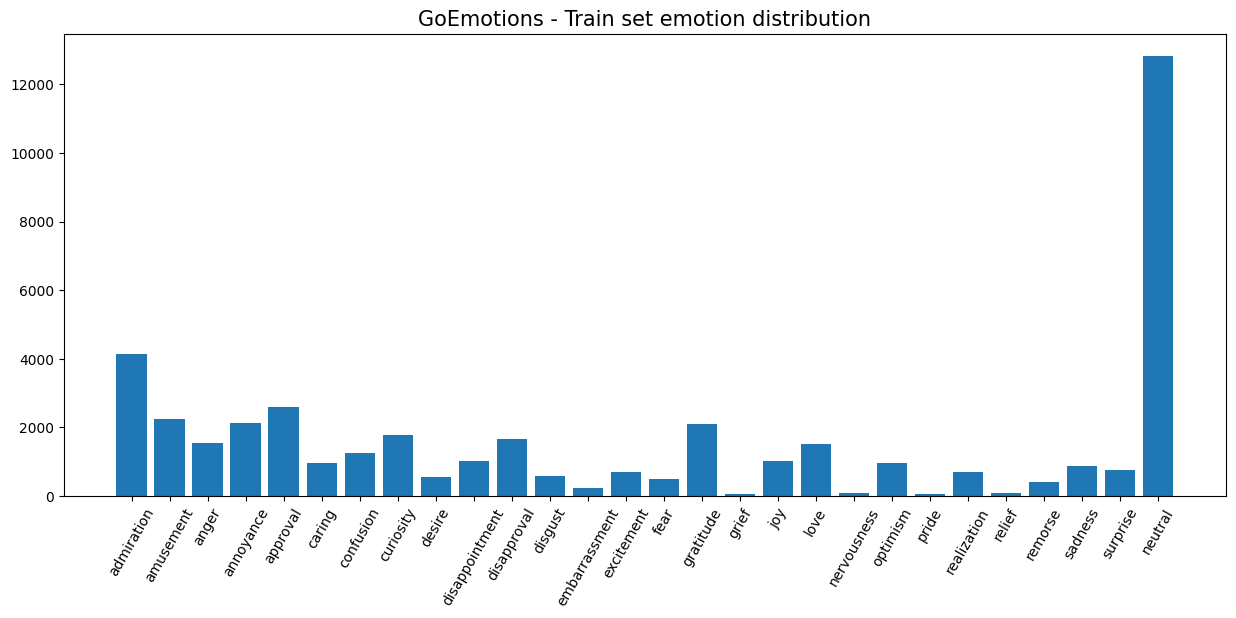

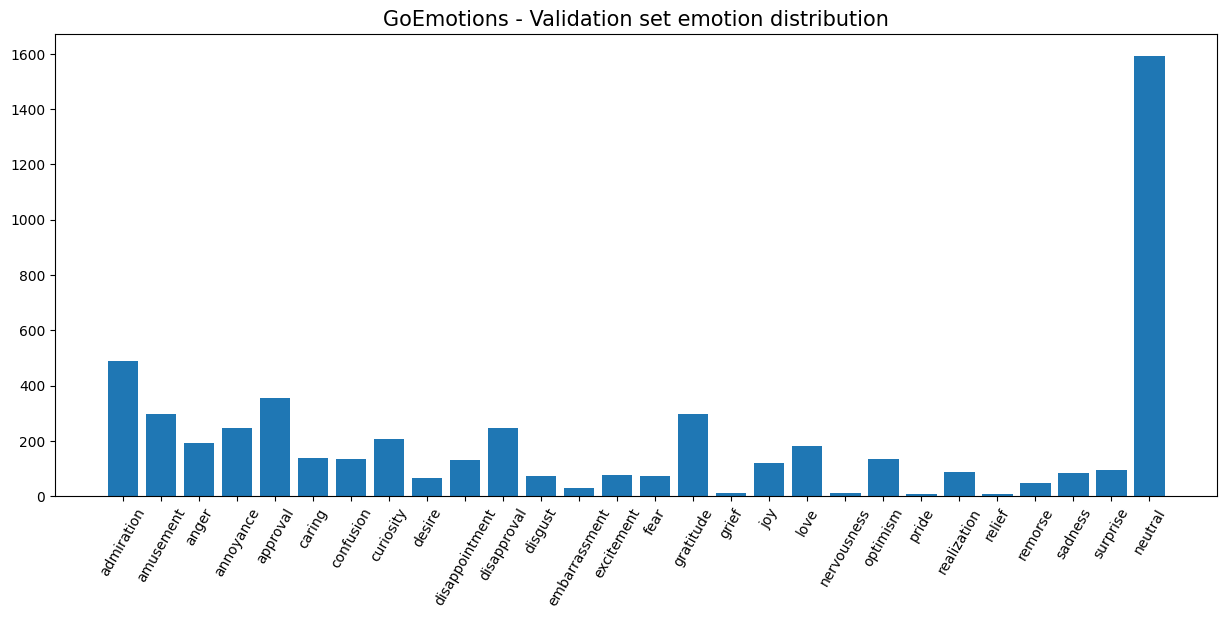

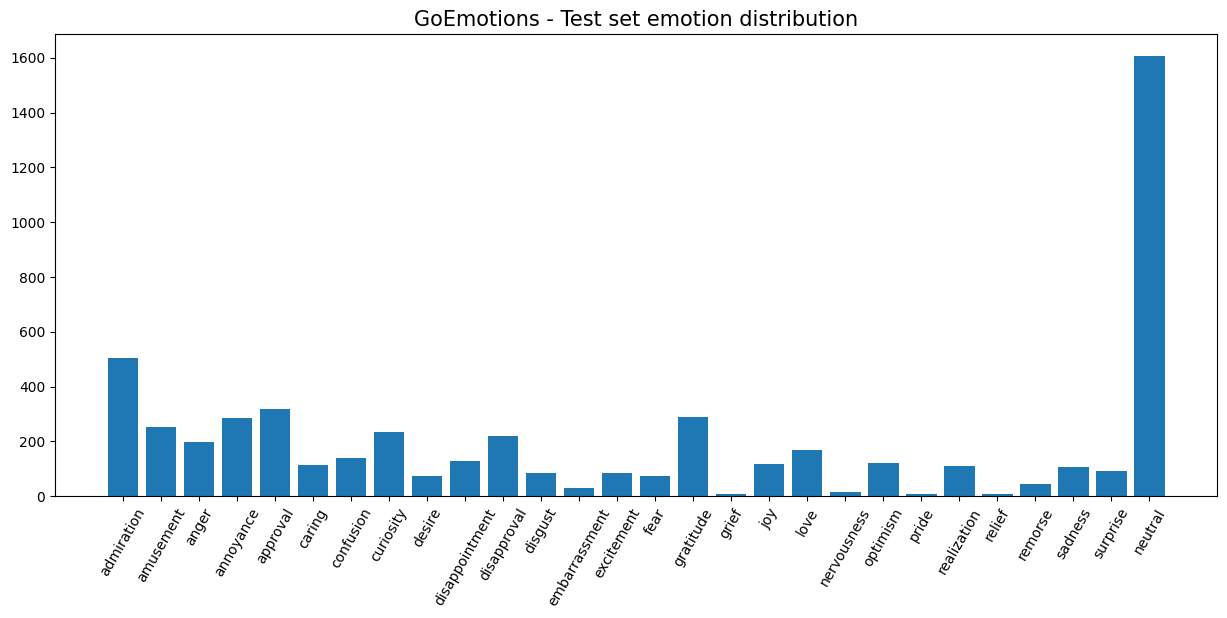

Number of samples in the Twitter dataset: 20000
Train set size: 16000
Validation set size: 2000
Test set size: 2000
====
Number of samples in the GoEmotions dataset: 54263
Train set size: 43410
Validation set size: 5426
Test set size: 5427


In [40]:
plot_label_distribution(train_set, __emotions, title="Twitter - Train set emotion distribution")
plot_label_distribution(val_set, __emotions, title="Twitter - Validation set emotion distribution")
plot_label_distribution(test_set, __emotions, title="Twitter - Test set emotion distribution")

plot_label_distribution(google_train_set, google__emotions, title="GoEmotions - Train set emotion distribution")
plot_label_distribution(google_val_set, google__emotions, title="GoEmotions - Validation set emotion distribution")
plot_label_distribution(google_test_set, google__emotions, title="GoEmotions - Test set emotion distribution")

print("Number of samples in the Twitter dataset:", len(train_set) + len(val_set) + len(test_set))
print("Train set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))
print("====")
print("Number of samples in the GoEmotions dataset:", len(google_train_set) + len(google_val_set) + len(google_test_set))
print("Train set size:", len(google_train_set))
print("Validation set size:", len(google_val_set))
print("Test set size:", len(google_test_set))

### Pre-process the dataset

Before using the dataset, we need to pre-process it.

We will:
- Remove the stopwords
- Remove the punctuation
- Lemmatize the text
- Convert the text to lowercase

We will pre-process the training dataset, for it to be ready to train on.

In [42]:
# First download the spacy model
!python -m spacy download en_core_web_sm # change to en_core_web_md or en_core_web_lg for larger models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 5.0 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [156]:
import spacy
from spacy.tokens import Doc

# load the English language model
nlp = spacy.load('en_core_web_sm') # change here too if you want to use a different model

"""
to pre-process the data, we will always apply the following:
- lowercasing
- removing extra whitespaces
"""
def pre_process(text: str) -> list[str]:
    tokens = nlp(text)
    return pre_process_doc(tokens)

def pre_process_doc(doc: Doc) -> list[str]:
    return [token.lemma_.lower().strip() for token in doc if not token.is_stop]

def pre_process_batch(texts: list[str]) -> list[list[str]]:
    processed_texts = []
    for doc in nlp.pipe(texts, batch_size=1024):  # Adjust batch_size based on memory
        processed_texts.append(pre_process_doc(doc))
        if len(processed_texts) % 1000 == 0:
            print("Processed", len(processed_texts), "/", len(texts))
    print("Processed", len(processed_texts), "/", len(texts))
    return processed_texts

pre_processed_train_set = [
    {"tokens": tokens, "label": train_set[i]["label"]}
    for i, tokens in enumerate(pre_process_batch([example["text"] for example in train_set]))
]

Processed 1000 / 43410
Processed 2000 / 43410
Processed 3000 / 43410
Processed 4000 / 43410
Processed 5000 / 43410
Processed 6000 / 43410
Processed 7000 / 43410
Processed 8000 / 43410
Processed 9000 / 43410
Processed 10000 / 43410
Processed 11000 / 43410
Processed 12000 / 43410
Processed 13000 / 43410
Processed 14000 / 43410
Processed 15000 / 43410
Processed 16000 / 43410
Processed 17000 / 43410
Processed 18000 / 43410
Processed 19000 / 43410
Processed 20000 / 43410
Processed 21000 / 43410
Processed 22000 / 43410
Processed 23000 / 43410
Processed 24000 / 43410
Processed 25000 / 43410
Processed 26000 / 43410
Processed 27000 / 43410
Processed 28000 / 43410
Processed 29000 / 43410
Processed 30000 / 43410
Processed 31000 / 43410
Processed 32000 / 43410
Processed 33000 / 43410
Processed 34000 / 43410
Processed 35000 / 43410
Processed 36000 / 43410
Processed 37000 / 43410
Processed 38000 / 43410
Processed 39000 / 43410
Processed 40000 / 43410
Processed 41000 / 43410
Processed 42000 / 43410
P

In [157]:

from collections import Counter
import numpy as np
from typing import Callable
from collections import defaultdict

"""
Multi-class, Uni-Label N-gram Naive Bayes Classifier
"""
class NBClassifier:
    """
    n: int The n-gram size
    labels: list[str] The list of labels
    pre_processor: Callable[[str], list[str]] The pre-processing function
    laplace_constant: int The Laplace smoothing constant
    alpha: float The alpha parameter for the reweighting of prior probabilities
    """
    def __init__(self, *, n, labels: list[str], pre_processor: Callable[[str], list[str]], laplace_constant=1, alpha=1):
        self.n = n
        self.labels = labels
        self.label_to_index = {label: index for index, label in enumerate(labels)}
        self.index_to_label = {index: label for index, label in enumerate(labels)}
        self.label_count_for_ngrams = Counter()
        self.label_percentage_for_ngrams = Counter()
        self.pre_processor = pre_processor
        self.prior = None

        # hyper parameters
        self.laplace_constant = laplace_constant
        self.log_laplace_constant = np.log(laplace_constant)
        self.alpha = alpha

    """
    Generate n-grams from a sentence
    """
    def ngrams(self, sentence: list[str]):
        for i in range(len(sentence) - self.n + 1):
            yield tuple(sentence[i:i + self.n])

    """
    Count the number of times each n-gram appears in each label
    """
    def get_label_counts_for_ngrams(self, pre_processed_dataset: list[dict[str: list[str] | int]]) -> Counter:
        label_count_for_ngrams = {}
        for example in pre_processed_dataset:
            for ngram in self.ngrams(example["tokens"]):
                if ngram not in label_count_for_ngrams:
                    label_count_for_ngrams[ngram] = {emotion: 0 for emotion in self.labels}
                emotion_index = example["label"]
                emotion = self.index_to_label[emotion_index]
                label_count_for_ngrams[ngram][emotion] += 1
        return label_count_for_ngrams

    """
    Convert counts to probabilities
    """
    def counts_to_probabilities(self, label_count_for_ngrams: Counter) -> Counter:
        label_prob_for_ngrams = Counter()
        for ngram, label_counts in label_count_for_ngrams.items():
            total = sum(label_counts.values())
            label_prob_for_ngrams[ngram] = {label: count / total for label, count in label_counts.items()}
        return label_prob_for_ngrams

    """
    Calculate the probability of an n-gram appearing in a label, from the counts of n-grams in each label
    """
    def proba_for_ngram_in_label(self, ngram, label: str):
        # Handle missing ngrams with Laplace smoothing
        if ngram not in self.label_count_for_ngrams:
            return self.laplace_constant / len(self.labels)

        # For seen ngrams, apply Laplace smoothing
        total_count = sum(self.label_count_for_ngrams[ngram].values())
        smoothed_count = self.label_count_for_ngrams[ngram][label] + self.laplace_constant
        return smoothed_count / (total_count + len(self.labels))

    """
    Calculate the probability of a sentence appearing in a label, by multiplying the probabilities of each n-gram
    """
    def prob_for_sentence_in_label(self, sentence: list[str], label: str):
        log_prob = 0
        for ngram in self.ngrams(sentence):
            prob = self.proba_for_ngram_in_label(ngram, label)
            if prob > 0:
                log_prob += np.log(prob)
            else:
                log_prob += (self.log_laplace_constant - np.log(len(self.labels)))
        return np.exp(log_prob)

    def get_emotion_counts(self, dataset):
        emotion_counts = {}
        for example in dataset:
            for emotion_index in [example["label"]]:
                emotion = self.index_to_label[emotion_index]
                if emotion not in emotion_counts:
                    emotion_counts[emotion] = 0
                emotion_counts[emotion] += 1
        # sort the emotions in the same order as the labels list
        emotion_counts = {emotion: emotion_counts[emotion] for emotion in self.labels}
        return emotion_counts

    """
    Calculate the prior probabilities of each label
    """
    def get_prior(self, pre_processed_dataset: list[dict[str: str | list[int]]]):
        label_counts = self.get_emotion_counts(pre_processed_dataset)
        total_examples = sum(label_counts[example] for example in label_counts)
        emotion_class_counts = {emotion: label_counts[emotion] for emotion in self.labels}
        return {emotion: count / total_examples for emotion, count in emotion_class_counts.items()}

    def proba_for_sentence_for_each_emo_ngram(self, sentence: list[str]):
        probas = {label: self.prob_for_sentence_in_label(sentence, label) for label in self.labels}
        # Reweight by prior probabilities
        probas = {label: (prob ** (1 - self.alpha)) * (self.prior[label] ** self.alpha) for label, prob in probas.items()}
        # Normalize to sum to 1
        total_proba = sum(probas.values())
        if total_proba > 0:
            probas = {label: prob / total_proba for label, prob in probas.items()}
        return probas

    def predict_label(self, sentence: str):
        pre_processed_sentence = self.pre_processor(sentence)
        probas = self.proba_for_sentence_for_each_emo_ngram(pre_processed_sentence)
        return sorted(probas.items(), key=lambda x: x[1], reverse=True)[:3]

    def train(self, pre_processed_dataset: list[dict[str: list[str] | int]]):
        self.label_count_for_ngrams = self.get_label_counts_for_ngrams(pre_processed_dataset)
        self.label_percentage_for_ngrams = self.counts_to_probabilities(self.label_count_for_ngrams)
        self.prior = self.get_prior(pre_processed_dataset)

# Instantiate the model and train it
model = NBClassifier(
    n=2,
    labels=__emotions,
    pre_processor=pre_process,
    laplace_constant=0.8,
    alpha=0.01875
)
model.train(pre_processed_train_set)

In [ ]:
emotion_count = {
    label: get_label_count(train_set, __emotions)[label]
    for label in __emotions
}

In [182]:
import matplotlib.pyplot as plt
from typing import Callable
from collections import defaultdict
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

%matplotlib inline

def evaluate(model: Callable[[str], str], test_set: list[dict[str: str | list[int]]]):
    correct_predictions = defaultdict(int)
    total_predictions = defaultdict(int)

    true_positives = defaultdict(int)
    false_positives = defaultdict(int)
    false_negatives = defaultdict(int)

    true_labels = []
    predicted_labels = []

    # Iterate over the test set
    for example in test_set:
        sentence = example["text"]
        true_label_index = example["label"]
        true_label = INDEX_TO_EMOTION[true_label_index]

        # Get predictions
        predicted_emotion = model(sentence)

        true_labels.append(true_label)
        predicted_labels.append(predicted_emotion)

        # Update counts for each true label
        total_predictions[true_label] += 1
        if predicted_emotion == true_label:
            correct_predictions[true_label] += 1
            true_positives[true_label] += 1
        else:
            false_negatives[true_label] += 1
            false_positives[predicted_emotion] += 1

    # Calculate accuracy, recall, precision and F1 score for each emotion
    metrics = {}
    for label in __emotions:
        tp = true_positives[label]
        fp = false_positives[label]
        fn = false_negatives[label]

        # Calculate precision
        precision = tp / (tp + fp) if tp + fp > 0 else 0

        # Calculate recall
        recall = tp / (tp + fn) if tp + fn > 0 else 0

        # Calculate F1 score
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

        metrics[label] = {
            "accuracy": correct_predictions[label] / total_predictions[label],
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score
        }

    # Calculate total accuracy
    total_accuracy = sum(correct_predictions.values()) / sum(total_predictions.values())

    return metrics, total_accuracy, true_labels, predicted_labels

def plot_eval(model: Callable[[str], str], test_set: list[dict[str: str | list[int]]], title: str):
    metrics, total_accuracy, true_labels, predicted_labels = evaluate(model, test_set)

    # Plot the accuracy for each emotion
    plt.figure(figsize=(15, 6))
    plt.bar(metrics.keys(), [metric["accuracy"] for metric in metrics.values()])
    plt.xticks(rotation=60)
    plt.ylabel("Accuracy")
    plt.title(title, fontsize=15)
    plt.ylim(0, 1)
    plt.show()

    # confusion matrix
    # cm = confusion_matrix(true_labels, predicted_labels, labels=__emotions, normalize="true")
    # disp = ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, labels=__emotions, normalize="true")
    # fig = disp.figure_
    # fig.set_figwidth(40)
    # fig.set_figheight(40)
    # disp.plot(cmap="Blues")
    # disp.im_.set_clim(0, 1)
    # plt.title(title)
    # plt.xticks(rotation=60)
    # plt.show()

    # plot the metrics in a double entry table, format: .2f
    metrics_table = []
    for emotion, metric in metrics.items():
        metrics_table.append([emotion, f"{metric['accuracy']:.2f}", f"{metric['precision']:.2f}", f"{metric['recall']:.2f}", f"{metric['f1_score']:.2f}"])
    metrics_table.append(["Total", f"{total_accuracy:.2f}", "", "", ""])
    plt.figure(figsize=(15, 10))
    plt.axis('off')
    # plot table, adding a little height padding
    plt.table(cellText=metrics_table, colLabels=["Emotion", "Accuracy", "Precision", "Recall", "F1 Score"], cellLoc="center", loc="center")
    plt.title(title, fontsize=15)
    plt.show()

    # print the metrics
    for label, metric in metrics.items():
        print(f"Emotion: {label}")
        print(f"Accuracy: {metric['accuracy']:.2f}")
        print(f"Precision: {metric['precision']:.2f}")
        print(f"Recall: {metric['recall']:.2f}")
        print(f"F1 Score: {metric['f1_score']:.2f}")
        print("====")

# 3 different models
def model_random(sentence: str) -> str:
    return np.random.choice(__emotions)

def model_majority(sentence: str) -> str:
    # find the most common emotion in the training set
    return max(emotion_count, key=lambda x: emotion_count[x])

def model_naive_bayes(sentence: str) -> str:
    return model.predict_label(sentence)[0][0]

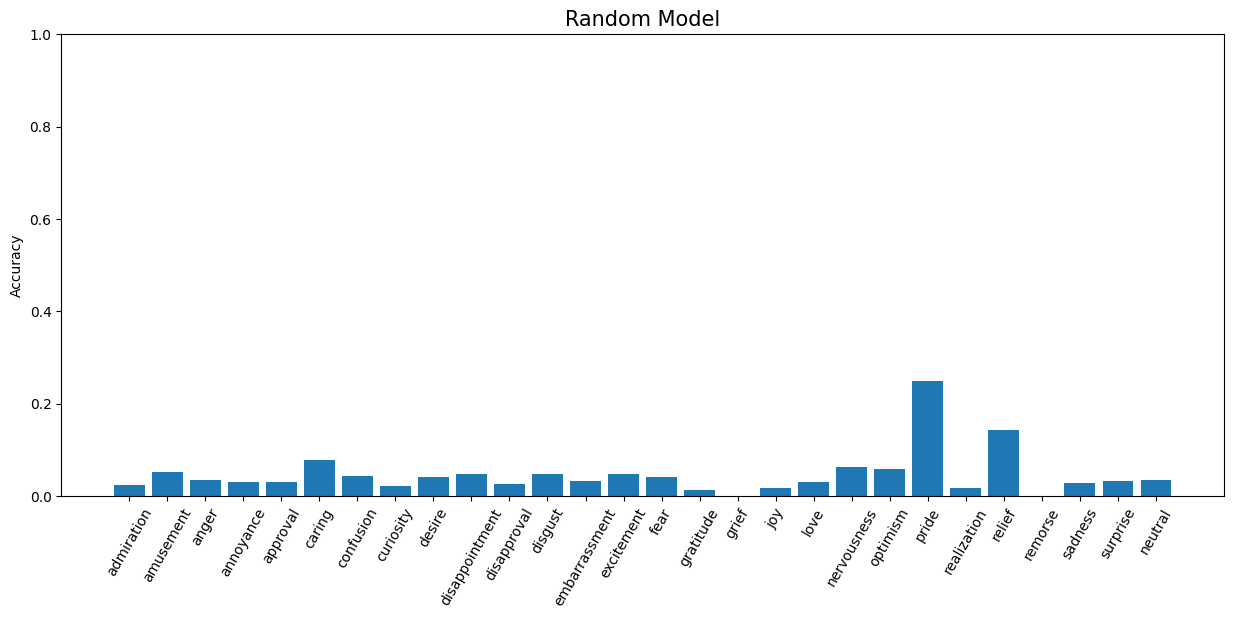

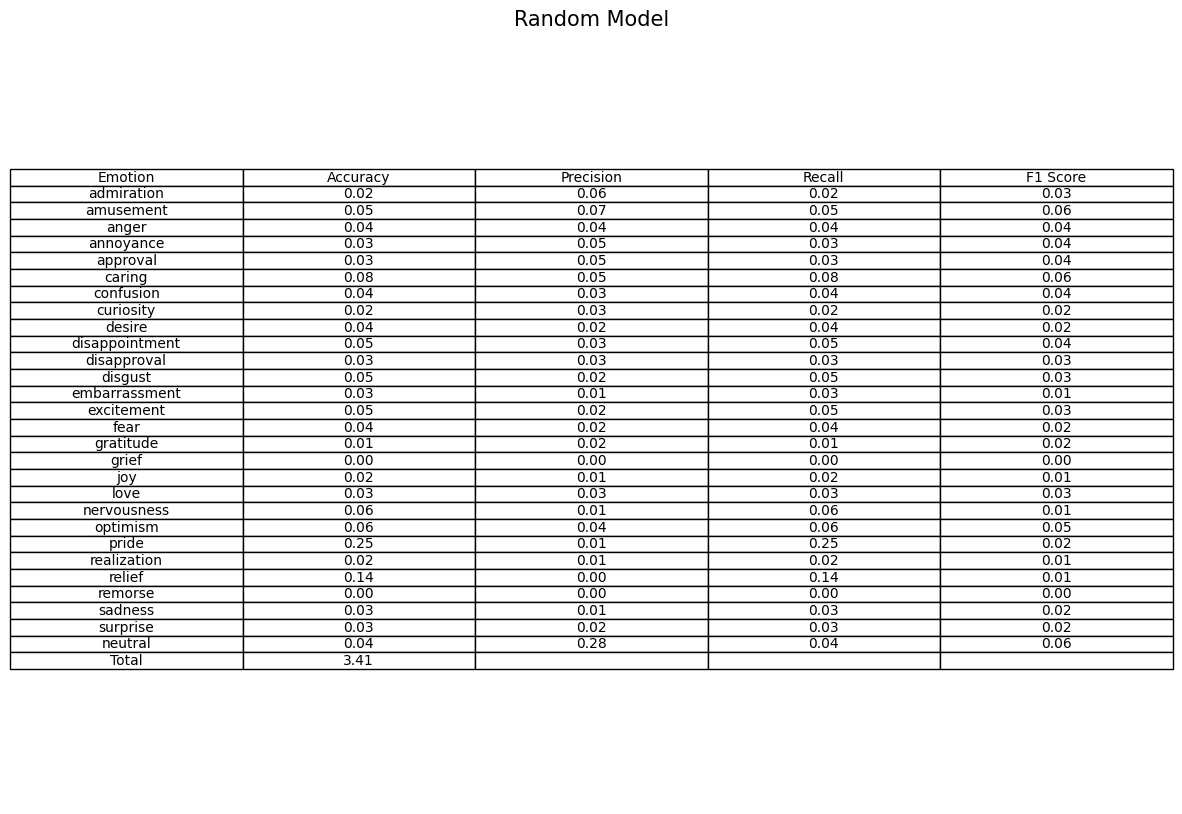

Emotion: admiration
Accuracy: 0.02
Precision: 0.06
Recall: 0.02
F1 Score: 0.03
====
Emotion: amusement
Accuracy: 0.05
Precision: 0.07
Recall: 0.05
F1 Score: 0.06
====
Emotion: anger
Accuracy: 0.04
Precision: 0.04
Recall: 0.04
F1 Score: 0.04
====
Emotion: annoyance
Accuracy: 0.03
Precision: 0.05
Recall: 0.03
F1 Score: 0.04
====
Emotion: approval
Accuracy: 0.03
Precision: 0.05
Recall: 0.03
F1 Score: 0.04
====
Emotion: caring
Accuracy: 0.08
Precision: 0.05
Recall: 0.08
F1 Score: 0.06
====
Emotion: confusion
Accuracy: 0.04
Precision: 0.03
Recall: 0.04
F1 Score: 0.04
====
Emotion: curiosity
Accuracy: 0.02
Precision: 0.03
Recall: 0.02
F1 Score: 0.02
====
Emotion: desire
Accuracy: 0.04
Precision: 0.02
Recall: 0.04
F1 Score: 0.02
====
Emotion: disappointment
Accuracy: 0.05
Precision: 0.03
Recall: 0.05
F1 Score: 0.04
====
Emotion: disapproval
Accuracy: 0.03
Precision: 0.03
Recall: 0.03
F1 Score: 0.03
====
Emotion: disgust
Accuracy: 0.05
Precision: 0.02
Recall: 0.05
F1 Score: 0.03
====
Emotion: 

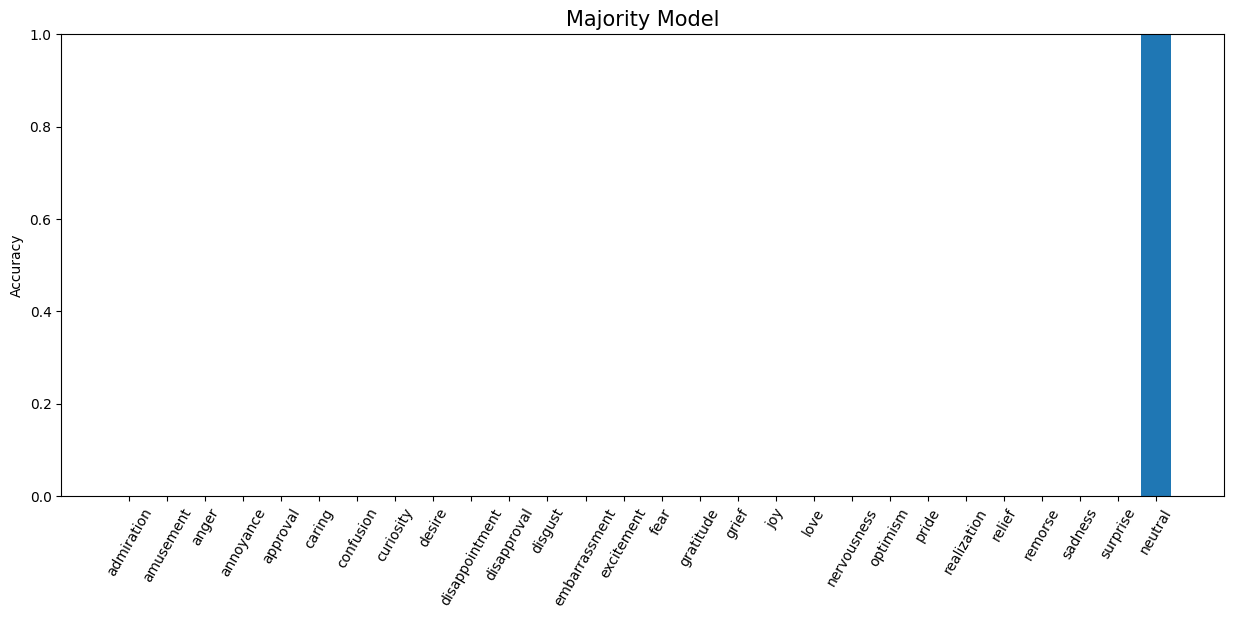

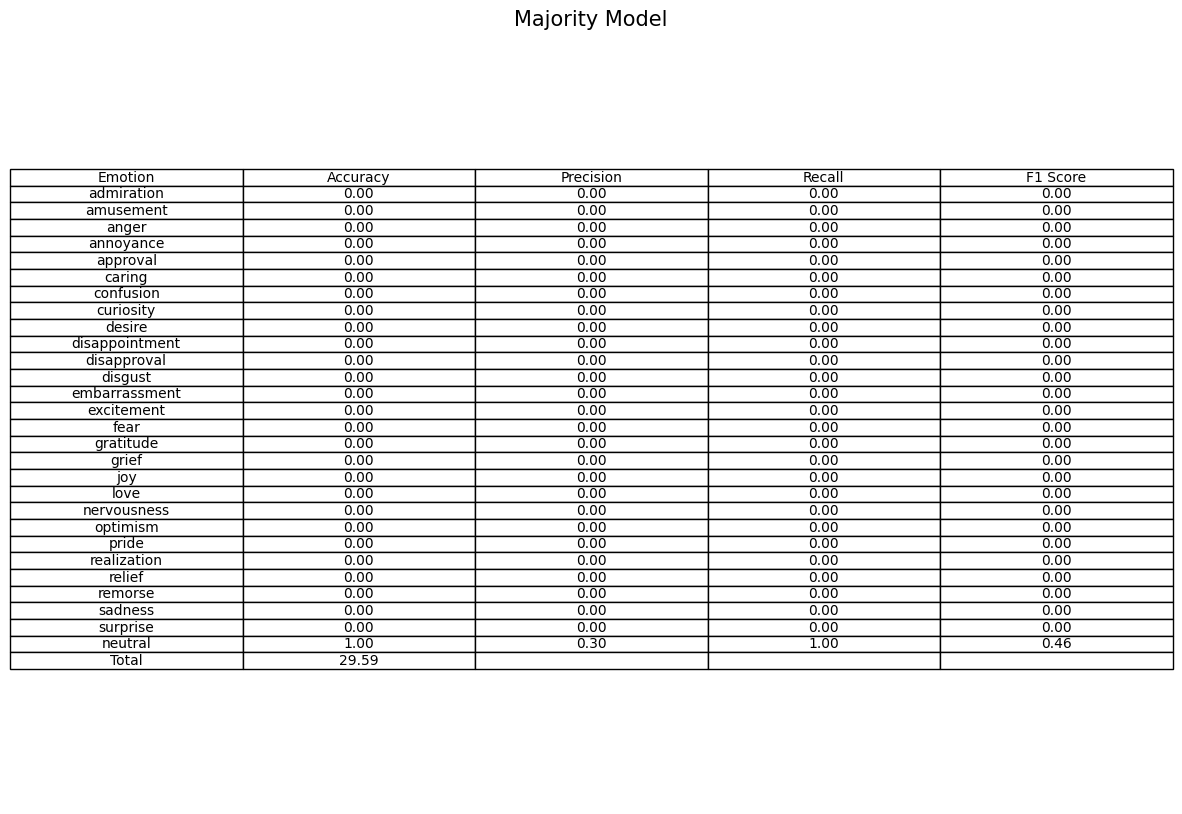

Emotion: admiration
Accuracy: 0.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
====
Emotion: amusement
Accuracy: 0.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
====
Emotion: anger
Accuracy: 0.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
====
Emotion: annoyance
Accuracy: 0.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
====
Emotion: approval
Accuracy: 0.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
====
Emotion: caring
Accuracy: 0.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
====
Emotion: confusion
Accuracy: 0.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
====
Emotion: curiosity
Accuracy: 0.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
====
Emotion: desire
Accuracy: 0.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
====
Emotion: disappointment
Accuracy: 0.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
====
Emotion: disapproval
Accuracy: 0.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
====
Emotion: disgust
Accuracy: 0.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
====
Emotion: 

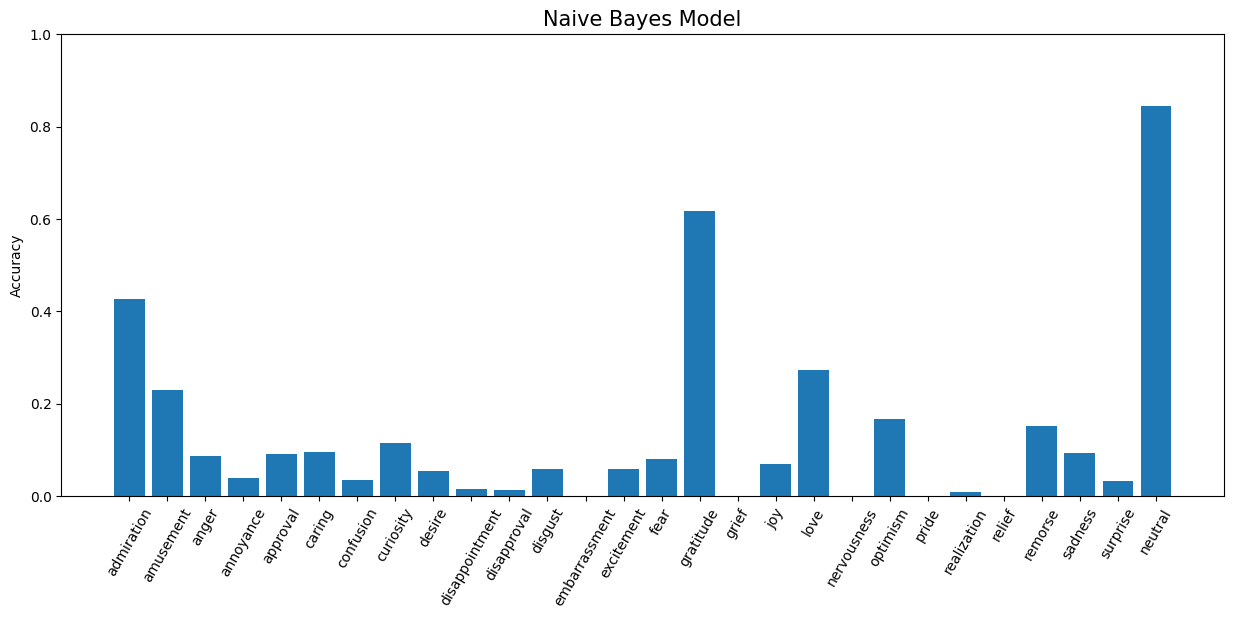

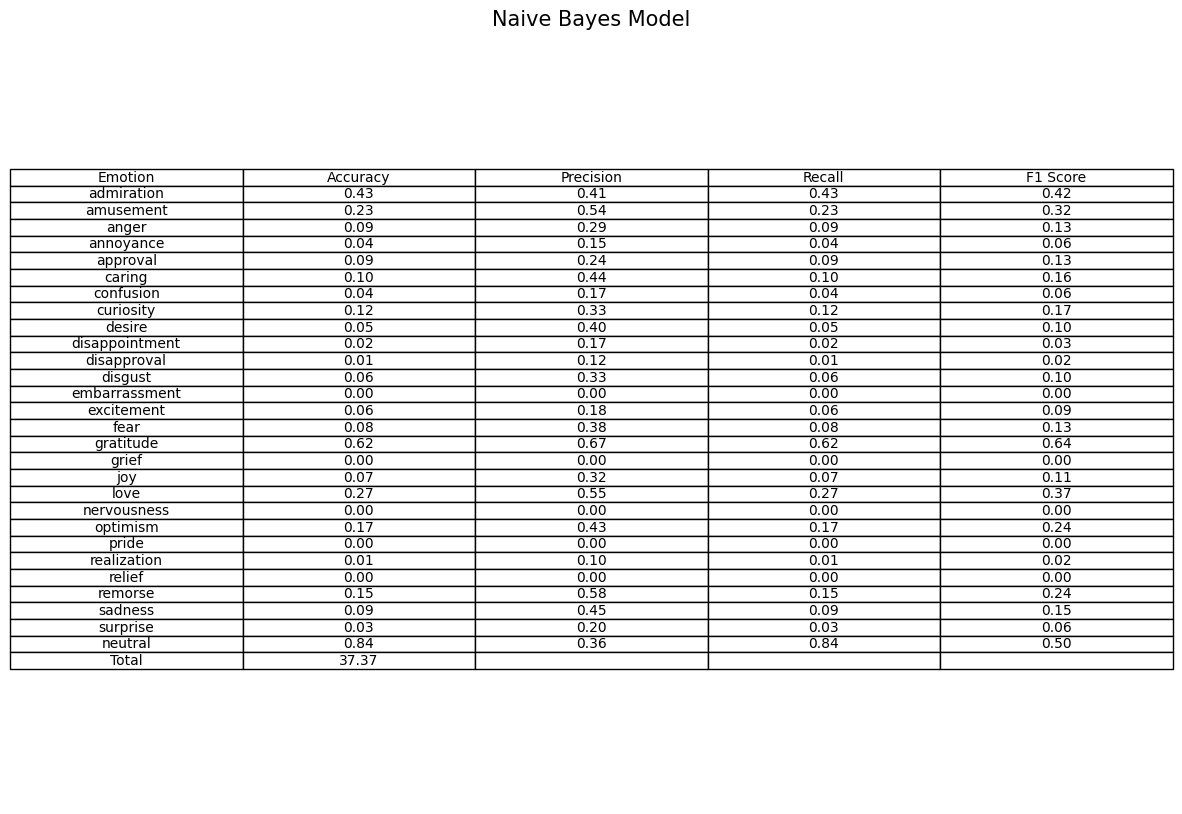

Emotion: admiration
Accuracy: 0.43
Precision: 0.41
Recall: 0.43
F1 Score: 0.42
====
Emotion: amusement
Accuracy: 0.23
Precision: 0.54
Recall: 0.23
F1 Score: 0.32
====
Emotion: anger
Accuracy: 0.09
Precision: 0.29
Recall: 0.09
F1 Score: 0.13
====
Emotion: annoyance
Accuracy: 0.04
Precision: 0.15
Recall: 0.04
F1 Score: 0.06
====
Emotion: approval
Accuracy: 0.09
Precision: 0.24
Recall: 0.09
F1 Score: 0.13
====
Emotion: caring
Accuracy: 0.10
Precision: 0.44
Recall: 0.10
F1 Score: 0.16
====
Emotion: confusion
Accuracy: 0.04
Precision: 0.17
Recall: 0.04
F1 Score: 0.06
====
Emotion: curiosity
Accuracy: 0.12
Precision: 0.33
Recall: 0.12
F1 Score: 0.17
====
Emotion: desire
Accuracy: 0.05
Precision: 0.40
Recall: 0.05
F1 Score: 0.10
====
Emotion: disappointment
Accuracy: 0.02
Precision: 0.17
Recall: 0.02
F1 Score: 0.03
====
Emotion: disapproval
Accuracy: 0.01
Precision: 0.12
Recall: 0.01
F1 Score: 0.02
====
Emotion: disgust
Accuracy: 0.06
Precision: 0.33
Recall: 0.06
F1 Score: 0.10
====
Emotion: 

In [183]:
plot_eval(model_random, test_set, "Random Model")
plot_eval(model_majority, test_set, "Majority Model")
plot_eval(model_naive_bayes, test_set, "Naive Bayes Model")

In [ ]:
from multiprocessing import Pool

def train_with(laplace, alpha, n):
    model = NBClassifier(
        n=n,
        labels=__emotions,
        pre_processor=pre_process,
        laplace_constant=laplace,
        alpha=alpha
    )
    def model_naive_bayes(sentence: str) -> str:
        return model.predict_label(sentence)[0][0]

    model.train(pre_processed_train_set)
    r = evaluate(model_naive_bayes, test_set)
    print(f"Alpha={alpha}, Laplace={laplace}, N={n}, Accuracy={r[0]}")
    return r

def grid_search():
    best_accuracy = 0
    best_params = None

    # first step
    laplaces = np.linspace(0, 1, 11)
    alphas = np.linspace(0, 1, 21)
    ns = [2]

    # 630sec for 70 combinations
    # -> 9sec for 1 combination
    # 49*101*70/60

    # second step
    # the best laplace is somewhere between 0.1 and 1
    # the best alpha is somewhere between 0 and 0.3
    # the best n is 2
    # laplaces = np.linspace(0.1, 1, 5)
    # alphas = np.linspace(0, 0.3, 5)
    # ns = [2]

    # third step
    # the best laplace is somewhere between 0.2 and 0.01
    # the best alpha is somewhere between 0 and 0.15
    # laplaces = np.linspace(0.55, 1, 5)
    # alphas = np.linspace(0, 0.15, 5)
    # ns = [2]

    # fourth step
    # the best laplace is somewhere between 0.9 and 0.7
    # the best alpha is somewhere between 0 and 0.075
    # laplaces = np.linspace(0.7, 0.9, 5)
    # alphas = np.linspace(0, 0.075, 5)
    # ns = [2]

    # Best parameters: Laplace=0.8, Alpha=0.01875, N=2
    params = [(laplace, alpha, n) for laplace in laplaces for alpha in alphas for n in ns]

    history = []
    # use multi threading to speed up the process
    with Pool() as p:
        results = p.starmap(train_with, [(laplace, alpha, n) for laplace, alpha, n in params])
        for i, (total_accuracy, _) in enumerate(results):
            if total_accuracy > best_accuracy:
                best_accuracy = total_accuracy
                best_params = (params[i][0], params[i][1], params[i][2])
            history.append((params[i][0], params[i][1], params[i][2], total_accuracy))

    print("Best parameters: Laplace={}, Alpha={}, N={}".format(best_params[0], best_params[1], best_params[2]))
    print("Best accuracy:", best_accuracy)
    return history

history = grid_search()

/tmp/ipykernel_501851/1690754822.py:29: RuntimeWarning: divide by zero encountered in log
  self.log_laplace_constant = np.log(laplace_constant)
/tmp/ipykernel_501851/1690754822.py:29: RuntimeWarning: divide by zero encountered in log
  self.log_laplace_constant = np.log(laplace_constant)
/tmp/ipykernel_501851/1690754822.py:29: RuntimeWarning: divide by zero encountered in log
  self.log_laplace_constant = np.log(laplace_constant)


Alpha=0.55, Laplace=0.1, N=2, Accuracy=34.69688594066703
Alpha=0.9500000000000001, Laplace=0.1, N=2, Accuracy=29.592776856458446
Alpha=0.4, Laplace=0.0, N=2, Accuracy=11.73760825502119
Alpha=0.0, Laplace=0.0, N=2, Accuracy=11.055831951354339
Alpha=0.8, Laplace=0.0, N=2, Accuracy=11.221669430624654
Alpha=0.15000000000000002, Laplace=0.1, N=2, Accuracy=34.23622627602727
Alpha=0.7000000000000001, Laplace=0.2, N=2, Accuracy=33.130643080891836
Alpha=0.30000000000000004, Laplace=0.2, N=2, Accuracy=34.49419568822554
Alpha=0.2, Laplace=0.1, N=2, Accuracy=34.21779988944168
Alpha=0.6000000000000001, Laplace=0.1, N=2, Accuracy=34.47576930163995
Alpha=0.8500000000000001, Laplace=0.0, N=2, Accuracy=11.055831951354339
Alpha=0.05, Laplace=0.0, N=2, Accuracy=11.866592961120324
Alpha=0.75, Laplace=0.2, N=2, Accuracy=31.95135433941404
Alpha=0.45, Laplace=0.0, N=2, Accuracy=11.73760825502119
Alpha=1.0, Laplace=0.1, N=2, Accuracy=29.592776856458446
Alpha=0.35000000000000003, Laplace=0.2, N=2, Accuracy=34.

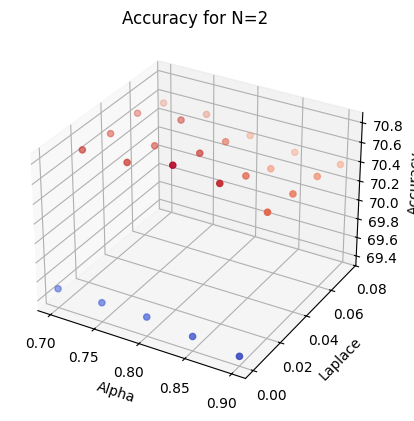

In [56]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def plot_3d_for_n(history, n, ax):
    alphas = [x[0] for x in history if x[2] == n]
    laplaces = [x[1] for x in history if x[2] == n]
    accuracies = [x[3] for x in history if x[2] == n]

    ax.scatter(alphas, laplaces, accuracies, c=accuracies, cmap=cm.coolwarm)
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Laplace')
    ax.set_zlabel('Accuracy')
    ax.set_title(f"Accuracy for N={n}")

def plot_3d(history, n):
    fig = plt.figure(n)
    ax = fig.add_subplot(111, projection='3d')

    alphas = [x[0] for x in history if x[2] == n]
    laplaces = [x[1] for x in history if x[2] == n]
    accuracies = [x[3] for x in history if x[2] == n]

    ax.scatter(alphas, laplaces, accuracies, c=accuracies, cmap=cm.coolwarm)
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Laplace')
    ax.set_zlabel('Accuracy')
    ax.set_title(f"Accuracy for N={n}")

# plot_3d(history, 1)
plot_3d(history, 2)
# plot_3d(history, 3)
# plot_3d(history, 4)

plt.show()